In [5]:
import numpy as np
import matplotlib.pyplot as plt

from trader import Trader
from order_book import OrderBook

import utilities

In [6]:
# initialise the trader and the order book
# here we will make just one trader make all the transactions
trader = Trader()

book = OrderBook()

np.random.seed(70)

In [7]:
tick_size = 1
simulation_length = 50


# new we want to generate some order book snapshot.
# to do this, let's first fill the order book with some random trades
book.asks = [(101, 5), (102, 7), (103,2)]
book.bids = [(99, 5), (98, 7), (97,2)]

mid_price = book.return_mid_price()

book.print_order_book_state()


# now let's do some random trades
# in this example, we set the quantity with a uniform distribution from 1 to 5.

while book.time < simulation_length:
  
    # update the mid price
    mid_price = book.return_mid_price()

    # random order type
    order_type = np.random.choice(['limit_sell', 'limit_buy', 'market_buy', 'market_sell'])

    # generate a random price
    if order_type  == 'limit_sell':
        price = int(mid_price + np.random.normal(0,1) + tick_size) // tick_size
    elif order_type == 'limit_buy':
        price = int(mid_price - np.random.normal(0,1) - tick_size) // tick_size
    else:
        price = None

    # generate a random quantity
    quantity = int(np.random.uniform(low=1, high=5))
    
    # submit the order to the order book
    trader.submit_order_to_order_book(
        order_type=order_type, 
        price=price, 
        quantity=quantity,
        book=book)


    # print the state of the book
    book.print_order_book_state()




Order book at time 0
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
|  103  |    2     | ask  |
|  102  |    7     | ask  |
|  101  |    5     | ask  |
|   99  |    5     | bid  |
|   98  |    7     | bid  |
|   97  |    2     | bid  |
+-------+----------+------+

market_buy - price: None - quantity: 3

Order book at time 1
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
|  103  |    2     | ask  |
|  102  |    7     | ask  |
|  101  |    2     | ask  |
|   99  |    5     | bid  |
|   98  |    7     | bid  |
|   97  |    2     | bid  |
+-------+----------+------+

limit_sell - price: 101 - quantity: 2

Order book at time 2
+-------+----------+------+
| price | quantity | side |
+-------+----------+------+
|  103  |    2     | ask  |
|  102  |    7     | ask  |
|  101  |    4     | ask  |
|   99  |    5     | bid  |
|   98  |    7     | bid  |
|   97  |    2     | bid  |
+-------+----------+------+

market_buy - p

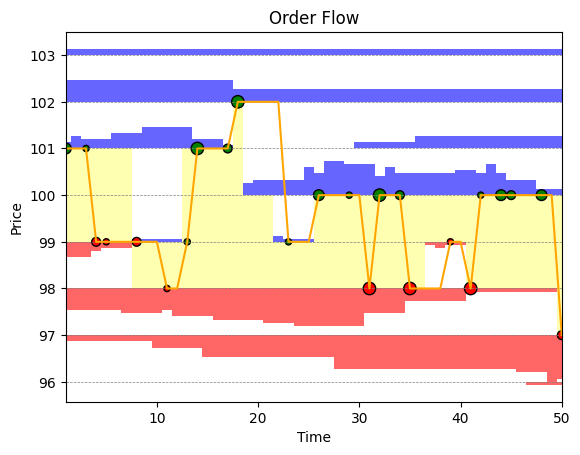

In [8]:
utilities.plot_order_flow(book.book_state_sequence, 
                          price_sequence=book.price_sequence, 
                          volumes_sequence=book.volumes_sequence, 
                          buy_sequence=book.buy_sequence, 
                          sell_sequence=book.sell_sequence
                          )